#### importing libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import sys
import cv2
from scipy.stats import bernoulli
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Flatten, Lambda, Activation, MaxPooling2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import pickle
from scipy.misc import imresize, imread
from random import randint
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization
#from preprocess import *
#import pydot

In [10]:
path = './data/driving_log.csv'
data = pd.read_csv(path)
img_cnt = data['center']     ## images from center camera
img_lft = data['left']    ## images from left camera
img_rgt = data['right']    ## images from right camera
img = np.concatenate((img_cnt, img_lft, img_rgt), axis=0)
print(img)
print(img.shape)

['IMG/center_2016_12_01_13_30_48_287.jpg'
 'IMG/center_2016_12_01_13_30_48_404.jpg'
 'IMG/center_2016_12_01_13_31_12_937.jpg' ...,
 ' IMG/right_2016_12_01_13_46_38_846.jpg'
 ' IMG/right_2016_12_01_13_46_38_922.jpg'
 ' IMG/right_2016_12_01_13_46_38_947.jpg']
(24108,)


#### showing csv in the form of data frame

In [11]:
def load_data(path):
    data = pd.read_csv(path)
    img_cnt = data['center']     ## images from center camera
    img_lft = data['left']    ## images from left camera
    img_rgt = data['right']    ## images from right camera
    img = np.concatenate((img_cnt,img_lft,img_rgt), axis=0)
    img = ["data/" + f.strip() for f in img]
    str_cnt_angle = data['steering'] ## Steering angle for images from center camera
    degrees = 6                     ## create adjusted steering measurements for the side camera images
    correction = degrees *0.01   
    steering_angle = np.concatenate((str_cnt_angle, str_cnt_angle + correction, str_cnt_angle - correction), axis=0)
    
    return img, steering_angle, data

In [12]:
path = './data/driving_log.csv'
img, steering, data = load_data(path)
print("number of images per camera is {}".format(len(img)))
print(type(img[0]))
print(imread(img[0]).shape)
print(img[8036])

number of images per camera is 24108
<class 'str'>
(160, 320, 3)
data/IMG/left_2016_12_01_13_30_48_287.jpg


#### Visualize Steering distribution

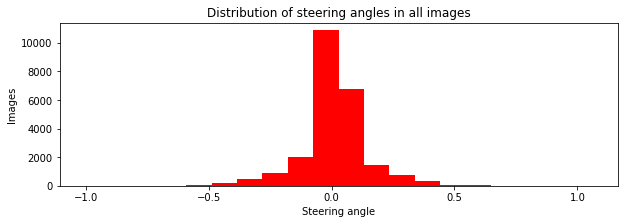

In [13]:
plt.figure(figsize=(10, 3))
plt.hist(steering, bins = 20, normed=0, histtype='stepfilled', color='r', alpha=1)
plt.xlabel("Steering angle")
plt.ylabel("Images")
plt.title("Distribution of steering angles in all images")
plt.show()

#### Displaying some random images from each camera

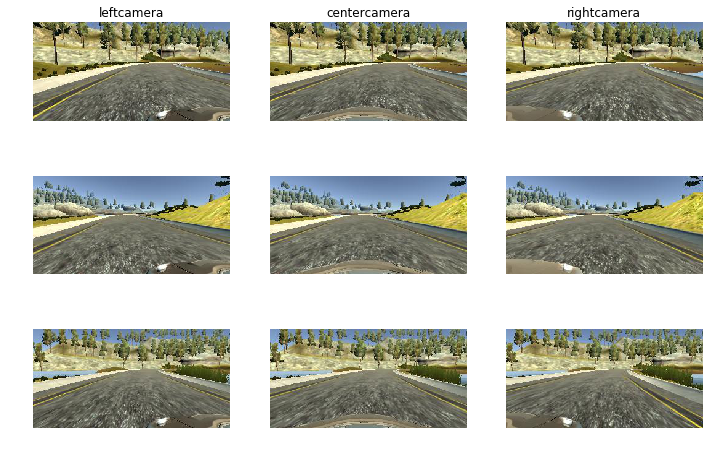

In [14]:
position = ['left', 'center', 'right']
number_images = data.shape[0]

def convert_path_to_image(index, position = 'center'):
    image = data.iloc[index][position]
    path = os.path.join('data', image.strip())
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
 
## display random images for each camera
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
for pos, ax in zip(position, axes[0, :]):
    ax.set_title(pos + 'camera')
for ax in axes:
    index = random.randrange(number_images)
    for a, pos in zip(ax, position) :
        image = convert_path_to_image(index, position=pos)
        a.imshow(image)
        a.axis('off')
plt.show()

#### Preprocessing methods

In [15]:
#Resize an image according to new size
def resize(image, size):
    image = imresize(image, size)
    return image

# Crops an image according to the  parameters, Returns an image cropped 40 pixels from top and 20 pixels from bottom.
def crop_image(image):
    return image[40:-20]

# Returns an image with a random degree of brightness.
# def random_brightness(image):
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     brightness = .25 + np.random.uniform()
#     image[:,:,2] = image[:,:,2] * brightness
#     image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
#     return image

# to preprocess the data
def preprocess(image, size=(64, 64)):
    new_image = crop_image(image)
    #new_image = random_brightness(new_image)
    new_image = resize(new_image, size)
    return new_image

In [16]:
def convert_path_to_image1(path):
    image = cv2.imread(path)
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image
new_images = []
for i in range(0, len(img)):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write(str(i))
    sys.stdout.flush()

    image = convert_path_to_image1(img[i])
    image = preprocess(image)
    new_images.append(image)


24107

In [17]:
## flipping image based on random outcome of coin flip, if the image will be flipped the steering angle should be negated
def flip(image, angle, flipping_prob=0.5):
    head = bernoulli.rvs(flipping_prob)
    if head:
        return np.fliplr(image), -1 * angle
    else:
        return image, angle

# ## Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk
# def random_shear(image, steering_angle, shear_range=200):
#     rows, cols, ch = image.shape
#     dx = np.random.randint(-shear_range, shear_range + 1)
#     random_point = [cols / 2 + dx, rows / 2]
#     pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
#     pts2 = np.float32([[0, rows], [cols, rows], random_point])
#     dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
#     M = cv2.getAffineTransform(pts1, pts2)
#     image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
#     steering_angle += dsteering

#     return image, steering_angle

In [18]:
def generate_image(images, angles):
    #image, steering_angle = random_shear(image, angle)
    augmented_images, augmented_angles = [], []
    flipped_images, flipped_angles = [], []

    for image, angle in zip(images, angles):
        augmented_images.append(image)
        augmented_angles.append(angle)

    for image, angle in zip(images, angles):
        flipped_images.append(np.fliplr(image))
        flipped_angles.append(angle * -1.0)

    for i in range(int(len(flipped_angles)/2)):
        random_int = randint(0, len(flipped_angles) - 1)
        augmented_images.append(flipped_images[random_int])
        augmented_angles.append(flipped_angles[random_int])
    
    x_train = np.array(augmented_images)
    y_train = np.array(augmented_angles)
    return x_train, y_train

In [19]:
def train_validation(image, angle,test_size):
    X_train, X_validation, y_train, y_validation = train_test_split(image, angle, test_size=test_size, random_state=0)
    return X_train, X_validation, y_train, y_validation

In [20]:
image, angle = generate_image(new_images, steering)
image, angle = shuffle(image, angle)
X_train, X_validation, y_train, y_validation = train_validation(image, angle, 0.2)

print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))

Training Set:   28929 samples
Validation Set: 7233 samples


### Model Architecture

In [21]:
# The model is based on NVIDIA's "End to End Learning for Self-Driving Cars" 
#tf.python.control_flow_ops = tf
def model_Nvidia(X_train)  :  
    number_of_epochs = 8
    keep_prob = 0.7
    learning_rate = 1e-4
    activation_relu = 'relu'
    model = Sequential()

    #model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))
    model.add(BatchNormalization(input_shape=X_train.shape[1:]))
    # Five convolutional and maxpooling layers
    model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation(activation_relu))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(Activation(activation_relu))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    model.add(Flatten())

    # Five fully connected layers
    model.add(Dense(1164))
    model.add(Activation(activation_relu))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(100))
    model.add(Activation(activation_relu))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(50))
    model.add(Activation(activation_relu))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(10))
    model.add(Activation(activation_relu))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate), loss="mse")
    checkpoint = ModelCheckpoint("model_val.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-4)    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=1, mode='min')
    outputs=[checkpoint, reduce_lr, early_stop]
    model.summary()
    
    return model, outputs

In [26]:
 model, outputs = model_Nvidia(X_train)

/Users/negin/extra_course/software/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), padding="same")`
/Users/negin/extra_course/software/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), padding="same")`
/Users/negin/extra_course/software/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), padding="same")`
/Users/negin/extra_course/software/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
/Users/negin/extra_course/software/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Co

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 24)        1824      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 24)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 36)        21636     
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 36)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 36)        0         
__________

In [27]:
def visualise_loss_data(history_object):
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

/Users/negin/extra_course/software/anaconda/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 23143 samples, validate on 5786 samples
Epoch 1/5
23143/23143 [==============================] - 159s - loss: 0.0334 - val_loss: 0.0182
Epoch 2/5
23143/23143 [==============================] - 582s - loss: 0.0190 - val_loss: 0.0182
Epoch 3/5
23143/23143 [==============================] - 162s - loss: 0.0190 - val_loss: 0.0182
Epoch 4/5
23143/23143 [==============================] - 173s - loss: 0.0189 - val_loss: 0.0182
Epoch 5/5
23143/23143 [==============================] - 182s - loss: 0.0189 - val_loss: 0.0182
dict_keys(['val_loss', 'loss'])


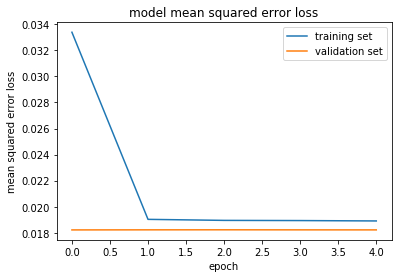

Saving data into model.h5
Model saved!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 24)        1824      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 24)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 36)        21636     
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 36)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1

In [29]:
history_object = model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5)

# train_gen = preprocess.generate_next_batch()
# validation_gen = preprocess.generate_next_batch()

# history = model.fit_generator(train_gen,
#                               samples_per_epoch=len(X_train),
#                               nb_epoch=5,
#                               validation_data=validation_gen,
#                               nb_val_samples=len(X_validation),
#                               verbose=1,
#                               callbacks=outputs)

visualise_loss_data(history_object)
print("Saving data into model.h5")
model.save('model.h5')
print("Model saved!")



# Save model architecture and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

#model.save_weights('model.h5')

# Show summary of model
model.summary()